#Mounting the drive folder
This is done to avoid uploading input files again and again if the colab runtime stops. This can be skipped while evaluating.

In [1]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/Avataar_Assignment" "/content/Avataar_Assignment"

Mounted at /gdrive


#Setting up Lang-Segment Model

In [2]:
!pip install torch torchvision --quiet
!pip install -U git+https://github.com/luca-medeiros/lang-segment-anything.git --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.9/91.9 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━

you can pass the image path here and text prompt here. Rest will be done by below code. The resulting masks are stored in Avataar_Assignment/masks folder. We are also saving bounding box masks considering practice with stable diffusion web platforms. There filled single component masks are mostly used.

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/groundingdino/models/GroundingDINO/ms_deform_attn.py:31: UserWarning: Failed to load custom C++ ops. Running on CPU mode Only!
  warnings.warn("Failed to load custom C++ ops. Running on CPU mode Only!")


final text_encoder_type: bert-base-uncased


Model loaded from /root/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


Downloading: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth" to /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████| 2.39G/2.39G [00:25<00:00, 101MB/s]


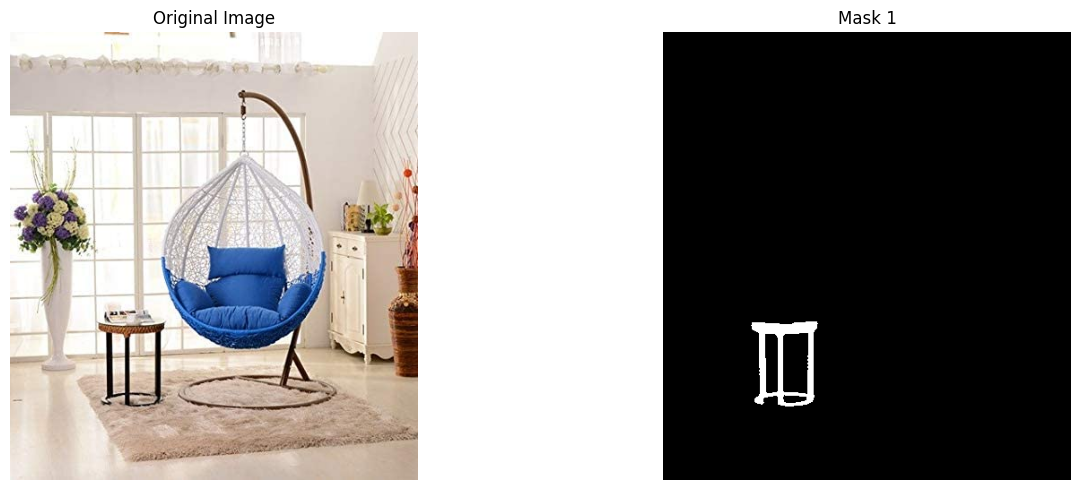

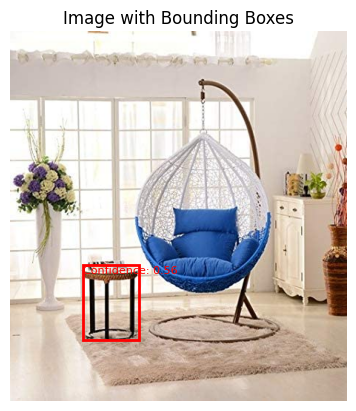

tensor([ 97.8155, 315.8789, 173.3863, 416.8523])
Bounding Boxes:
Box 1: tensor([ 97.8155, 315.8789, 173.3863, 416.8523])

Detected Phrases:
Phrase 1: stool

Confidence:
Logit 1: 0.5592383146286011


In [3]:
image = "/content/Avataar_Assignment/stool.jpeg"
text_prompt = "stool"

import warnings
import numpy as np
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from lang_sam import LangSAM



def download_image(url):
    response = requests.get(url)
    response.raise_for_status()
    return Image.open(BytesIO(response.content)).convert("RGB")

def save_mask(mask_np, filename):
    mask_image = Image.fromarray((mask_np * 255).astype(np.uint8))
    mask_image.save(filename)

def display_image_with_masks(image, masks):
    num_masks = len(masks)

    fig, axes = plt.subplots(1, num_masks + 1, figsize=(15, 5))
    axes[0].imshow(image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    for i, mask_np in enumerate(masks):
        axes[i+1].imshow(mask_np, cmap='gray')
        axes[i+1].set_title(f"Mask {i+1}")
        axes[i+1].axis('off')

    plt.tight_layout()
    plt.show()

def display_image_with_boxes(image, boxes, logits):
    fig, ax = plt.subplots()
    ax.imshow(image)
    ax.set_title("Image with Bounding Boxes")
    ax.axis('off')

    for box, logit in zip(boxes, logits):
        x_min, y_min, x_max, y_max = box
        confidence_score = round(logit.item(), 2)  # Convert logit to a scalar before rounding
        box_width = x_max - x_min
        box_height = y_max - y_min

        # Draw bounding box
        rect = plt.Rectangle((x_min, y_min), box_width, box_height, fill=False, edgecolor='red', linewidth=2)
        ax.add_patch(rect)

        # Add confidence score as text
        ax.text(x_min, y_min, f"Confidence: {confidence_score}", fontsize=8, color='red', verticalalignment='top')

    plt.show()

def print_bounding_boxes(boxes):
    print("Bounding Boxes:")
    for i, box in enumerate(boxes):
        print(f"Box {i+1}: {box}")

def print_detected_phrases(phrases):
    print("\nDetected Phrases:")
    for i, phrase in enumerate(phrases):
        print(f"Phrase {i+1}: {phrase}")

def print_logits(logits):
    print("\nConfidence:")
    for i, logit in enumerate(logits):
        print(f"Logit {i+1}: {logit}")
def main():
    # Suppress warning messages
    warnings.filterwarnings("ignore")

    try:
        if image.startswith("http"):
            image_pil = download_image(image)
        else:
            image_pil = Image.open(image).convert("RGB")

        model = LangSAM()
        masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)

        if len(masks) == 0:
            print(f"No objects of the '{text_prompt}' prompt detected in the image.")
        else:
            # Convert masks to numpy arrays
            masks_np = [mask.squeeze().cpu().numpy() for mask in masks]

            # Display the original image and masks side by side
            display_image_with_masks(image_pil, masks_np)

            # Display the image with bounding boxes and confidence scores
            display_image_with_boxes(image_pil, boxes, logits)

            # Save the masks
            for i, mask_np in enumerate(masks_np):
                mask_path = "Avataar_Assignment/masks/{}_mask_{}.png".format(text_prompt, i)

                # we are also saving a box mask considering practice with stable diffusion web platforms
                box_mask_path = "Avataar_Assignment/masks/{}_box_mask_{}.png".format(text_prompt, i)
                x_min, y_min, x_max, y_max = boxes[i]
                print(boxes[i])
                box_mask = np.zeros((image_pil.size[0],image_pil.size[1]),dtype=np.uint8) # initialize mask
                box_mask[int(x_min):int(x_max),int(y_min):int(y_max)] = 255 # fill with white pixels

                save_mask(mask_np, mask_path)
                save_mask(box_mask, box_mask_path)

            # Print the bounding boxes, phrases, and logits
            print_bounding_boxes(boxes)
            print_detected_phrases(phrases)
            print_logits(logits)

    except (requests.exceptions.RequestException, IOError) as e:
        print(f"Error: {e}")

if __name__ == "__main__":
    main()